In [328]:
#-*- coding:utf8-*-
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy as sp
import scipy.constants as const
import sympy as sym
import pandas as pd
import ROOT as rt
import root_numpy as rnp
from aputils.latextables.tables import Table
from IPython.display import Image

#import sys
#reload(sys)
#sys.setdefaultencoding('utf-8')
import seaborn as sns
sns.set()

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]

#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
#plt.rcParams['xtick.major.pad']='8'
#plt.rcParams['ytick.major.pad']='8'


#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [329]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, axis="x"):
    if axis == "x":
        plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")
        
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)

# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

## Vorbereitungsaufgaben

Nullstellen 1000mm: [ 1400.]
Stabilitätsparameter 1000mm: [  4.93038066e-32]

Nullstellen 1400mm: [ 1000.  1400.]
Stabilitätsparameter 1400mm: [  0.00000000e+00   8.88178420e-17]

Maximalstellen 1000mm: [    0.  2800.]
Stabilitätsparameter 1000mm: [ 1.  1.]

Maximalstellen 1400mm: [    0.  2400.]
Stabilitätsparameter 1400mm: [ 1.  1.]



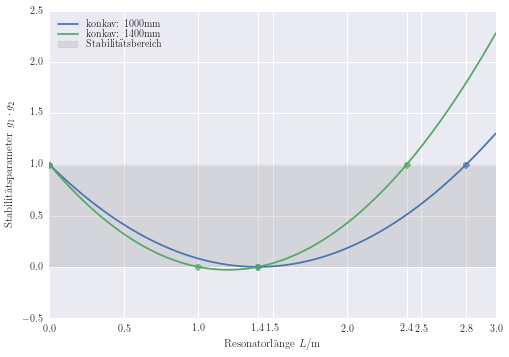

In [330]:
def stability_condition(L, r_1, r_2=None):
    g_1 = 1 - L/r_1
    if r_2 == None:
        g_2 = 1
    else:
        g_2 = 1 - L/r_2
    return g_1 * g_2 

# Minimum der Kurven => Maximum der Länge
def maximum_resonator_length(r_1,r_2):
    return (r_1 + r_2)/2
    


# Resonatorlängen
resonator_length = np.arange(0,3,0.001)
zeros = np.zeros_like(resonator_length)
mirror_radii = {'OC':1.4,'flat':None,'HR1':1.4,'HR2':1.0}

# Array der Stabilitätsparameter
# Stabilitätsparameter für zwei unteschiedliche Radien: 1400mm; 1000mm
stability_hr1 = stability_condition(resonator_length, mirror_radii["OC"],mirror_radii["HR1"])
# Stabilitätsparameter für zwei gleiche Radien: 1400mm
stability_hr2 = stability_condition(resonator_length, mirror_radii["OC"],mirror_radii["HR2"])

zero_crossing_L_hr1 = np.where((stability_hr1<1e-07)&(stability_hr1>-1e-07))[0]
zero_crossing_L_hr2 = np.where((stability_hr2<1e-07)&(stability_hr2>-1e-07))[0]

zero_crossing_hr1 = np.array([zero_crossing_L_hr1,[stability_hr1[i] for i in zero_crossing_L_hr1]])
zero_crossing_hr2 = np.array([zero_crossing_L_hr2,[stability_hr2[i] for i in zero_crossing_L_hr2]])

print("Nullstellen 1000mm:", zero_crossing_hr1[0])
print(u"Stabilitätsparameter 1000mm:",zero_crossing_hr1[1],end="\n\n")
print("Nullstellen 1400mm:",zero_crossing_hr2[0])
print(u"Stabilitätsparameter 1400mm:",zero_crossing_hr2[1],end="\n\n")

one_crossing_L_hr1 = np.where((stability_hr1<1+1e-07)&(stability_hr1>1-1e-07))[0]
one_crossing_L_hr2 = np.where((stability_hr2<1+1e-07)&(stability_hr2>1-1e-07))[0]

one_crossing_hr1 = np.array([one_crossing_L_hr1,[stability_hr1[i] for i in one_crossing_L_hr1]])
one_crossing_hr2 = np.array([one_crossing_L_hr2,[stability_hr2[i] for i in one_crossing_L_hr2]])
print("Maximalstellen 1000mm:", one_crossing_hr1[0])
print(u"Stabilitätsparameter 1000mm:",one_crossing_hr1[1],end="\n\n")
print("Maximalstellen 1400mm:", one_crossing_hr2[0])
print(u"Stabilitätsparameter 1400mm:", one_crossing_hr2[1],end="\n\n")

# Plot

# Plot des Bereichs zwischen 0 und 1
plt.barh(0,3,height=1,color="gray",alpha=0.2,edgecolor="gray",label="Stabilitätsbereich")
# Plot der Graphen
lines_hr1 = plt.plot(resonator_length,stability_hr1,label="konkav: 1000mm")
lines_hr2 = plt.plot(resonator_length,stability_hr2,label="konkav: 1400mm")

color_hr1 = lines_hr1[0].get_color()
color_hr2 = lines_hr2[0].get_color()
#Plot der Stellen
plt.plot(zero_crossing_hr1[0]/1000,zero_crossing_hr1[1]/1000,"o",color=color_hr1,alpha=0.75)
plt.plot(zero_crossing_hr2[0]/1000,zero_crossing_hr2[1]/1000,"o",color=color_hr2,alpha=0.75)
plt.plot(one_crossing_hr1[0]/1000,one_crossing_hr1[1],"o",color=color_hr1,alpha=0.75)
plt.plot(one_crossing_hr2[0]/1000,one_crossing_hr2[1],"o",color=color_hr2,alpha=0.75)

# Hinzufügen der extra Achseneinteilungen
ax = plt.gca()
xticks = [0.0,0.5,1.0,1.5,2.0,2.5,3.0]
#xticks_minor = list()
for hr1 in zero_crossing_hr1[0]:
    xticks.append(hr1/1000)
for hr1,hr2 in zip(one_crossing_hr1[0],one_crossing_hr2[0]):
    if not hr1/1000 in xticks: #and not hr1/1000 in xticks_major:
        xticks.append(hr1/1000)
    if not hr2/1000 in xticks: #and not hr2/1000 in xticks_major:
        xticks.append(hr2/1000)  
        
#ax.xaxis.set_ticks(xticks_major)
#ax.xaxis.set_ticks(np.round(xticks_minor,decimals=1), minor=True)
ax.xaxis.set_ticks(xticks)
#ax.xaxis.set_ticklabels(map(str,xticks_minor), minor=True)
# Ploteinstellungen 
plt.xlabel(axis_label(u"Resonatorlänge",sym="L",unit="m"))
plt.ylabel(axis_label(u"Stabilitätsparameter",sym="g_1\cdot g_2"))
plt.grid(True,which="major")

# Plot der Legende
plt.legend(loc="best",frameon=False,labelspacing=0.15)
#Speichern des Plots
plt.savefig(path_graphics+"Stabilitaetsparameter.pdf")

##Messung der TEM_00 

In [331]:
# Laden der Messdaten: Position in x Richtung und Photostrom
pos_x, photo_current = np.loadtxt(path_data+"TEM_00.txt",unpack=True)
#Laden der Fehler
error_position, error_current = np.loadtxt(path_data+"TEM_Fehler.txt",unpack=True)

#Verschiebung der Messwerte um Offset (setzt den Nullpunkt beim maximalen Messwert)
pos_x = pos_x + 22

# Fehlerbehaftete Messwerte
pos_x_err = unp.uarray(pos_x, [error_position]*len(pos_x))
photo_current_err = unp.uarray(photo_current,[error_current]*len(photo_current))

# Skalierung auf SI Einheiten
pos_x_err = pos_x_err * 1e-3  # m
photo_current_err = photo_current_err*1e-05  # A
#Normirung auf maximum
#photo_current_err = photo_current_err/max(noms(pos_x_err))

In [332]:
#Gausverteiltung
def gauss(x, a, sig):
    return a * np.exp(-np.power(2*(x),2.) / (2 *np.power(sig,2.)))

popt,pcov = sp.optimize.curve_fit(gauss, noms(pos_x_err), noms(photo_current_err),sigma=stds(photo_current_err),
                                  p0=[1,0.2], absolute_sigma=True)

param_err = fit_errors(popt,pcov)
print_errors(param_err,["Maximalintensität I_0","Strahlbreite w"])

Maximalintensität I_0  3.17836425029e-05 +/- 3.51838588946e-08
Strahlbreite w         0.0145329570585 +/- 2.21455314836e-05


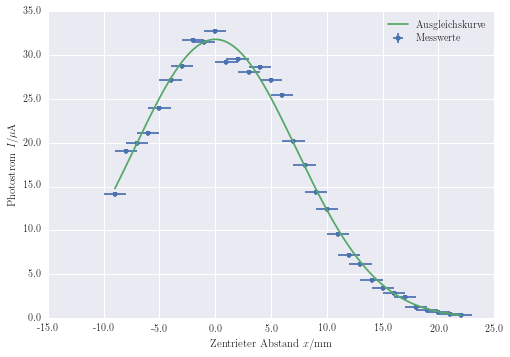

In [333]:
#Plot der Messwerte
min_x,max_x = min(noms(pos_x_err)),max(noms(pos_x_err))
X = np.arange(min_x,max_x,0.00001)
fit_gauss = gauss(X,*popt)

plt.xlabel(axis_label("Zentrieter Abstand",sym="x",unit="mm"))
plt.ylabel(axis_label("Photostrom",sym="I",unit="\mu A"))
axis_scale(1e+3,axis="x")
axis_scale(1e+6,axis="y")


plt.errorbar(noms(pos_x_err), noms(photo_current_err), xerr=stds(pos_x_err), yerr=stds(photo_current_err),
             fmt=".", markersize=10, label="Messwerte")
plt.plot(X, fit_gauss,label="Ausgleichskurve")
plt.legend(loc="best")
plt.savefig(path_graphics+"TEM_00.pdf")

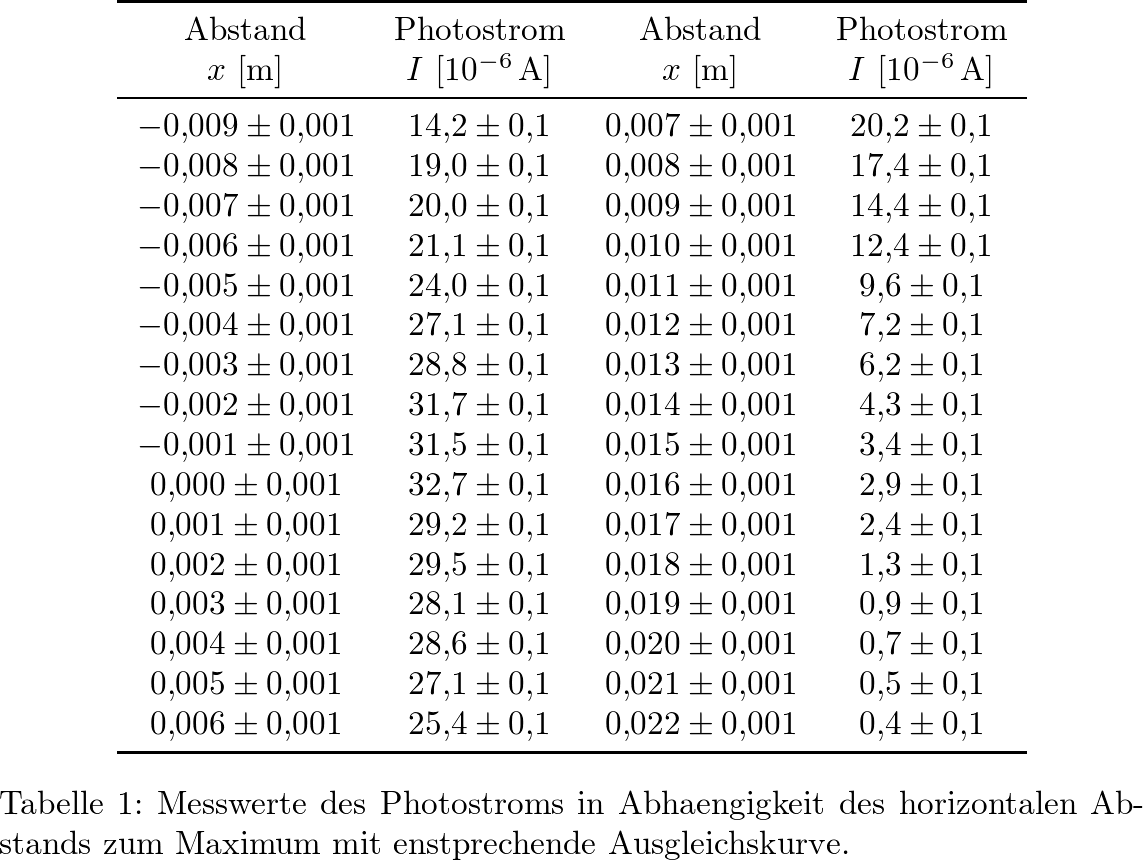

In [334]:
#Tabelle der Messwerte
T = Table(siunitx=True, booktabs=True)
T.caption("Messwerte des Photostroms in Abhaengigkeit des horizontalen Abstands zum Maximum mit enstprechende Ausgleichskurve.")
T.label("TEM00")
T.addColumn(pos_x_err[:16],title="Abstand",symbol="x",unit="m")
T.addColumn(photo_current_err[:16]*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
T.addColumn(pos_x_err[16:],title="Abstand",symbol="x",unit="m")
T.addColumn(photo_current_err[16:]*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
Image(T.show(ipynb=True),height=320)
#T.save(path_table+"Tabelle_TEM00.tex")


## Messung der TEM_10 

In [335]:
# Laden der Messdaten: Position in x Richtung und Photostrom
pos_x, photo_current = np.loadtxt(path_data+"TEM_10.txt",unpack=True)
#Laden der Fehler
error_position, error_current = np.loadtxt(path_data+"TEM_Fehler.txt",unpack=True)

#Verschiebung der Messwerte um Offset (setzt den Nullpunkt beim maximalen Messwert)
pos_x = pos_x + 22

# Fehlerbehaftete Messwerte
pos_x_err = unp.uarray(pos_x, [error_position]*len(pos_x))
photo_current_err = unp.uarray(photo_current,[error_current]*len(photo_current))

# Skalierung auf SI Einheiten
pos_x_err = pos_x_err * 1e-3  # m
photo_current_err = photo_current_err*1e-05  # A


In [336]:
#Gausverteiltung
def gauss2(r, a, w):
    return a * (2*np.power((r),2.)/(np.power(w,2.))) * np.exp(-2*np.power(r,2.) / (np.power(w,2.)))

popt,pcov = sp.optimize.curve_fit(gauss2, noms(pos_x_err), noms(photo_current_err),sigma=stds(photo_current_err),
                                  p0=[3e-06,0.2], absolute_sigma=True)

param_err = fit_errors(popt,pcov)
print_errors(param_err,["Maximalintensität I_0","Strahlbreite w"])

Maximalintensität I_0  6.98533023857e-06 +/- 7.91583310554e-08
Strahlbreite w         -0.01281502869 +/- 0.000101158988474


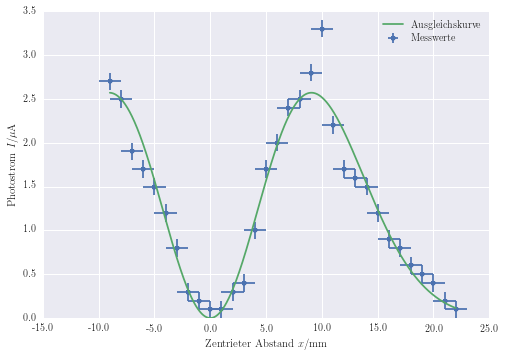

In [337]:
#Plot der Messwerte
min_x,max_x = min(noms(pos_x_err)),max(noms(pos_x_err))
X = np.arange(min_x,max_x,0.00001)
fit_gauss = gauss2(X,*popt)

plt.xlabel(axis_label("Zentrieter Abstand",sym="x",unit="mm"))
plt.ylabel(axis_label("Photostrom",sym="I",unit="\mu A"))
axis_scale(1e+3,axis="x")
axis_scale(1e+6,axis="y")


plt.errorbar(noms(pos_x_err), noms(photo_current_err), xerr=stds(pos_x_err), yerr=stds(photo_current_err),
             fmt=".", markersize=10, label="Messwerte")
plt.plot(X, fit_gauss,label="Ausgleichskurve")
plt.legend(loc="best")
plt.savefig(path_graphics+"TEM_10.pdf")


In [338]:
#Tabelle der Messwerte
T = Table(siunitx=True, booktabs=True)
T.caption("Messwerte des Photostroms in Abhaengigkeit des horizontalen Abstands zum Maximum mit entsprechender Ausgleichskurve.")
T.label("TEM10")
T.addColumn(pos_x_err[:16],title="Abstand",symbol="x",unit="m")
T.addColumn(photo_current_err[:16]*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
T.addColumn(pos_x_err[16:],title="Abstand",symbol="x",unit="m")
T.addColumn(photo_current_err[16:]*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
Image(T.show(ipynb=True),height=320)
T.save(path_table+"Tabelle_TEM10.tex")

## Messung der Polarisation

In [339]:
# Laden der Messdaten: Winkel und Photostrom
angle, photo_current = np.loadtxt(path_data+"Polarisation.txt",unpack=True)

#Winkel zu Bogenmaß
angle = np.deg2rad(angle)

#Laden der Fehler
error_angle, error_current = np.loadtxt(path_data+"Polarisation_Fehler.txt",unpack=True)

#Winkel zu Bogenmaß
error_angle = np.deg2rad(error_angle)

# Fehlerbehaftete Messwerte
angle_err = unp.uarray(angle, [error_angle]*len(angle))
photo_current_err = unp.uarray(photo_current,[error_current]*len(photo_current))

# Skalierung auf SI Einheiten
photo_current_err = photo_current_err*1e-06  # A

In [340]:
#Sinusquadratverteilung
def sin2(p, I0, p0):
    return I0*np.power(np.sin(p - p0),2)

popt,pcov = sp.optimize.curve_fit(sin2, noms(angle), noms(photo_current_err),sigma=stds(photo_current_err),
                                  p0=[17e-06,np.deg2rad(50)], absolute_sigma=True)

param_err = fit_errors(popt,pcov)
print_errors(param_err,["Maximalintensität I_0","Phase phi_0"])


Maximalintensität I_0  1.56217702188e-05 +/- 3.84900177443e-08
Phase phi_0            2.42987521953 +/- 0.00213377505421


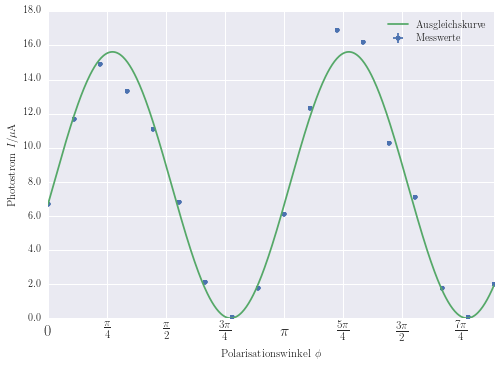

In [341]:
#Plot der Messwerte
min_x,max_x = min(noms(angle_err)),max(noms(angle_err))
X = np.arange(min_x,max_x,0.01)
fit_sin2 = sin2(X,*popt)

#Achseneinstellungen
ax = plt.gca()
ax.xaxis.set_ticks([0,const.pi/4,const.pi/2,3*const.pi/4,const.pi,5*const.pi/4,3*const.pi/2,7*const.pi/4,2*const.pi])
ax.xaxis.set_ticklabels([r"$0$",r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$",r"$\frac{3\pi}{4}$",r"$\pi$",
                         r"$\frac{5\pi}{4}$",r"$\frac{3\pi}{2}$",r"$\frac{7\pi}{4}$",r"$2\pi$"],fontsize=16)
plt.xlabel(axis_label("Polarisationswinkel",sym="\phi"))
plt.ylabel(axis_label("Photostrom",sym="I",unit="\mu A"))
axis_scale(1e+6,axis="y")


plt.errorbar(noms(angle), noms(photo_current_err), xerr=stds(angle), yerr=stds(photo_current_err),
             fmt=".", markersize=10, label="Messwerte")
plt.plot(X, fit_sin2,label="Ausgleichskurve")
plt.legend(loc="best")
plt.savefig(path_graphics+"Polarisation.pdf")


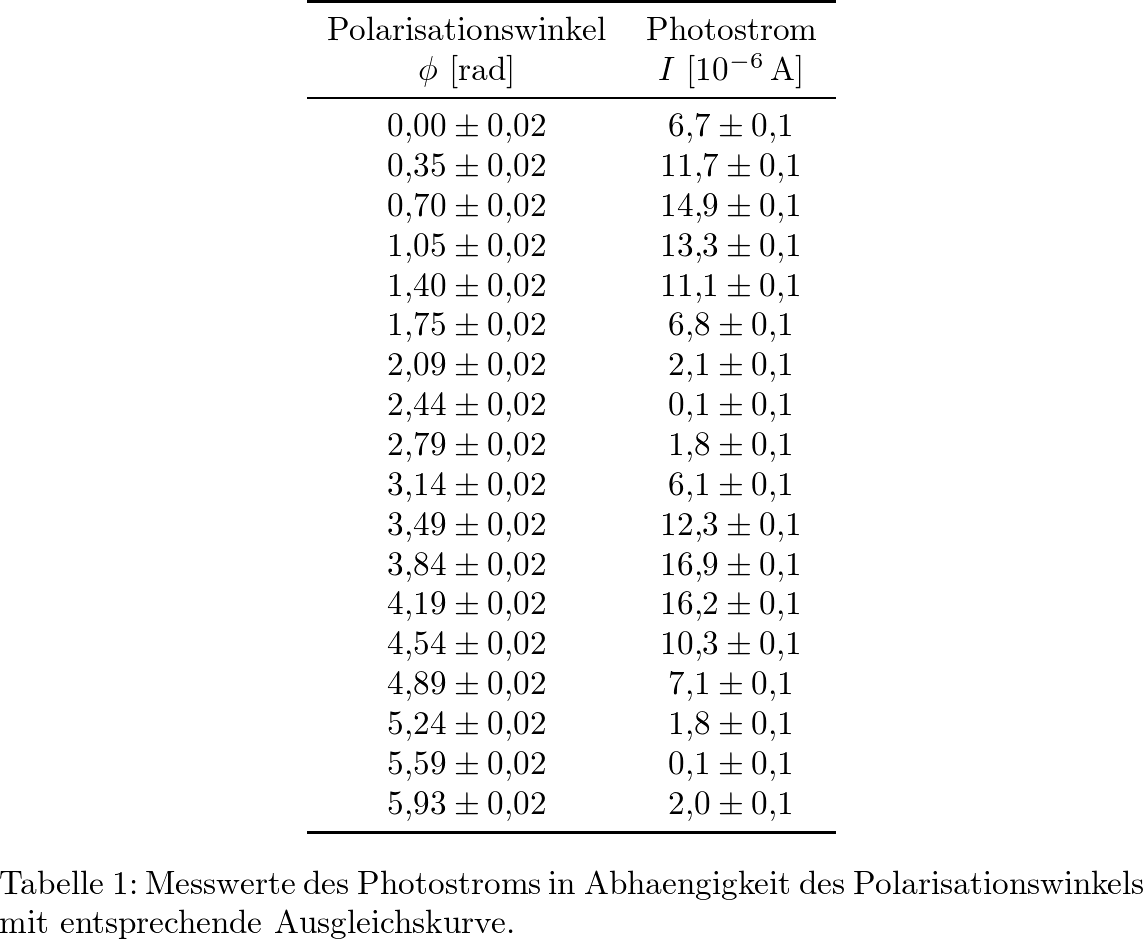

In [342]:
#Tabelle der Messwerte
T = Table(siunitx=True, booktabs=True)
T.caption("Messwerte des Photostroms in Abhaengigkeit des Polarisationswinkels mit entsprechende Ausgleichskurve.")
T.label("Polarisation")
T.addColumn(angle_err,title="Polarisationswinkel",symbol=r"\phi",unit=r"rad")
T.addColumn(photo_current_err*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
#T.addColumn(pos_x_err[16:],title="Abstand",symbol="x",unit="m")
#T.addColumn(photo_current_err[16:]*1e06,title="Photostrom",symbol=r"I",unit=r"\micro\ampere")
Image(T.show(ipynb=True),height=320)
#T.save(path_table+"Tabelle_Polarisation.tex")

## Messung der Wellenlänge

In [343]:
# Laden der Messdaten
dist_2_max, dist_2_grating = np.loadtxt(path_data+"Wellenlaenge.txt",unpack=True)

#Laden der Fehler
error_dist = np.loadtxt(path_data+"Wellenlaenge_Fehler.txt",unpack=True)

# Fehlerbehaftete Messwerte
dist_2_max_err = unp.uarray(dist_2_max, [error_dist]*len(dist_2_max))
dist_2_grating_err = unc.ufloat(dist_2_grating[0],error_dist)


# Gitter
lines_per_mm = 100 
dist_lines = 1/lines_per_mm 

# Skalierung auf SI Einheiten
dist_2_max_err = dist_2_max_err*1e-02  # m
dist_2_grating_err = dist_2_grating_err*1e-02  # m
dist_lines = dist_lines * 1e-03 #m


# Berechnung des Tangens 
tan_angle_err = dist_2_max_err/dist_2_grating_err 
# Berechnung des Winkels
angle_err = unp.arctan(tan_angle)


# Berechnung der Wellenlänge
sin_angle_err = unp.sin(angle_err)
dist_num_max = dist_lines/np.array([1,2,3,4,5])
wavelength_err = sin_angle_err * dist_num_max
print_errors(wavelength_err)
print("Systematischer Fehler", umean(wavelength))
wavelength_mean = np.mean(noms(wavelength_err))
wavelength_std = np.std(noms(wavelength_err))/np.sqrt(len(noms(wavelength_err)))
print("Statistischer Fehler", wavelength_mean,"+/-",wavelength_std)

6.4382277998e-07 +/- 9.17838638046e-09
6.39856688151e-07 +/- 4.53282643661e-09
6.3340635522e-07 +/- 2.96126474662e-09
6.33050811865e-07 +/- 2.15640430216e-09
6.3612429681e-07 +/- 1.6568414189e-09
Systematischer Fehler (6.373+/-0.023)e-07
Statistischer Fehler 6.37252186405e-07 +/- 1.82942865116e-09


In [344]:
#Tabelle der Messwerte
T = Table(siunitx=True, booktabs=True)
T.caption("Messwerte der Abstaende zwischen den Maxima dem Hauptmaximum und die resultierenden Winkel und Wellenlaengen.")
T.label("Wellenlaengen")
T.addColumn(dist_2_max_err,title="Abstand",symbol="d",unit="m")
T.addColumn(angle_err,title="Winkel",symbol=r"\theta",unit="rad")
T.addColumn(wavelength_err*1e06,title="Wellenlaenge",symbol=r"\lambda",unit=r"\micro\meter")

Image(T.show(ipynb=True),height=320)
T.save(path_table+"Tabelle_Wellenlaengen.tex")

## Stabilitätsbedingung

In [359]:
# Laden der Messdaten
length_resonator, photo_current = np.loadtxt(path_data+"Stabilitaetsbedingung.txt",unpack=True)

#Laden der Fehler
error_length, error_current = np.loadtxt(path_data+"Polarisation_Fehler.txt",unpack=True)

# Fehlerbehaftete Messwerte
length_resonator_err = unp.uarray(length_resonator, [error_length]*len(length_resonator))
photo_current_err = unp.uarray(photo_current,[error_current]*len(photo_current))

# Skalierung auf SI Einheiten
length_resonator_err = length_resonator_err * 1e-02
photo_current_err = photo_current_err * 1e-05

# Entfernen des schlechten Messwerts 
photo_current_err = np.delete(photo_current_err,5)
length_resonator_err = np.delete(length_resonator_err,5)
photo_current_err_ = photo_current_err.copy()
photo_current_err /=max(noms(photo_current_err) )
photo_current_err *= stability_condition(0.65,mirror_radii["OC"],mirror_radii["HR2"])


In [360]:
#Quadratische Funktion
def square(x, a, b, c):
    return a * x**2 + x*b + c
def exp(x,a,b,c):
    return a * np.exp(x*b) +c
popt,pcov = sp.optimize.curve_fit(exp, noms(length_resonator_err), noms(photo_current_err),
                                  sigma=stds(photo_current_err),p0=[1/(1.4)**2,2/1.4,1],absolute_sigma=True)

param_err = fit_errors(popt,pcov)
print_errors(param_err,["Maximalintensität I_0","Phase phi_0"])

-0.178994702585 +/- 0.0839329244135
1.03244851343 +/- 0.255511629044
0.534099448621 +/- 0.107397401999


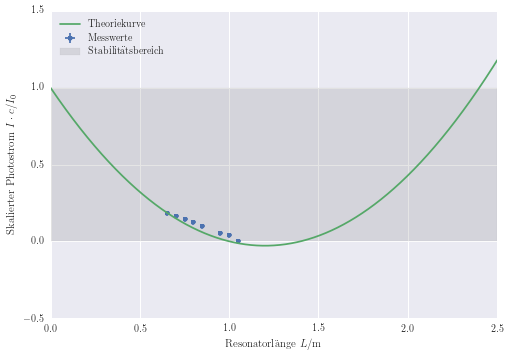

In [361]:
#Plot der Messwerte
min_x,max_x = min(noms(length_resonator_err)),max(noms(length_resonator_err))
X = np.arange(min_x,max_x,0.01)
#X = np.arange(-10,10,0.01)
fit_square = square(X,*popt)


plt.xlim(0.,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel(axis_label("Resonatorlänge",sym="L",unit="m"))
plt.ylabel(axis_label("Skalierter Photostrom",sym="I\cdot c/I_0"))

#plt.plot(X, fit_square,label="Ausgleichskurve")

plt.errorbar(noms(length_resonator_err), noms(photo_current_err), 
             xerr=stds(length_resonator_err), yerr=stds(photo_current_err),
             fmt=".", markersize=10, label="Messwerte")
plt.plot(resonator_length,stability_hr2,label="Theoriekurve")
plt.barh(0,2.5,height=1,color="gray",alpha=0.2,edgecolor="gray",label="Stabilitätsbereich")
plt.legend(loc="best")
plt.savefig(path_graphics+"Stabilitaetsbedingung.pdf")

In [370]:
#Tabelle der Messwerte
T = Table(siunitx=True, booktabs=True)
T.caption("Messwerte des Photostroms und der daraus berechnete, skalierter Photostrom, in Abhaengigkeit der Resonatorlaenge.")
T.label("Stabilitaet")
T.addColumn(length_resonator_err,title="Resonatorlaenge",symbol=r"L",unit=r"\meter")
T.addColumn(photo_current_err_*1e03,title="Photostrom",symbol=r"I",unit=r"\milli\ampere")
T.addColumn(photo_current_err,title="Skalierter Photostrom",symbol=r"\frac{I\cdot c}{I_0}")

Image(T.show(quiet=False,ipynb=True),height=320)
T.save(path_table+"Tabelle_Stabilitaet.tex")